In [1]:
import re
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
def select_gpu(N):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print(gpus)
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_visible_devices(gpus[N], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)    

In [3]:
select_gpu(0)
epochs = 10
batch_size = 1024
model_name = 'bert-chinese'
embedding_path = '/home/Danny/pretrain_model/{}'.format(model_name)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
3 Physical GPUs, 1 Logical GPUs


In [4]:
# 不用儲存article_id, 轉成list
def training_txt_to_list(path):
    with open(path, 'r') as f:
        txt = str(f.read())
    txt_list = txt.split('\n')
    text_label_list = list()
    tmp = list()
    for line in txt_list:
        if line == '--------------------':
            text_label_list.append(tmp)
            tmp = list()
            continue
        if line == '':
            continue
        tmp.append(line)
    x = list()
    y = list()
    for text_label in text_label_list:
        text = text_label[0]
        label = text_label[2:]
        label_list = ['O' for i in range(len(text))]
        for i in label:
            entity = i.split('\t')
            if int(entity[1]) > int(entity[2]):
                continue
            b = int(entity[1])
            label_list[b] = 'B-{}'.format(entity[-1])
            for j in range(int(entity[1])+1, int(entity[2])):
                label_list[j] = 'I-{}'.format(entity[-1])
        for i, j in enumerate(text):
            if j == '，' or j == '。' or j == '？':
                label_list[i] = j
                
        text_list = re.split('\uff0c|\u3002|\uff1f', text)
        for sentence in text_list:
            x.append([i for i in sentence])
        x = x[:-1]
            
        sentence = list()
        for i in label_list:
            if i == '，' or i == '。' or i == '？':
                y.append(sentence)
                sentence = list()
            else:
                sentence.append(i)
                
    return [x, y]

In [5]:
x1, y1 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage1/SampleData_deid.txt')

In [6]:
x2, y2 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage2/train_1_update.txt')

In [7]:
x4, y4 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage4/train_2.txt')

In [8]:
x = x1 + x2 + x4
y = y1 + y2 + y4
print(len(x))
print(len(y))

76162
76162


In [9]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))
print(len(test_x), len(test_y))

48743 48743
12186 12186
15233 15233


In [10]:
%%time
import kashgari
from kashgari.tasks.labeling import BiLSTM_CRF_Model
from kashgari.embeddings import BertEmbedding
kashgari.config.use_cudnn_cell = True
bert_embedding = BertEmbedding(embedding_path, 
                           sequence_length='auto',
                           trainable=True,
                           task='kashgari.LABELING', 
                          )
model = BiLSTM_CRF_Model(bert_embedding)
history = model.fit(train_x,
                    train_y,
                    valid_x,
                    valid_y,
                    epochs=epochs,
                    batch_size=batch_size,
                   )

2020-12-15 10:30:51,551 [DEBUG] kashgari - ------------------------------------------------
2020-12-15 10:30:51,551 [DEBUG] kashgari - Loaded transformer model's vocab
2020-12-15 10:30:51,552 [DEBUG] kashgari - config_path       : /home/Danny/pretrain_model/bert-chinese/bert_config.json
2020-12-15 10:30:51,552 [DEBUG] kashgari - vocab_path      : /home/Danny/pretrain_model/bert-chinese/vocab.txt
2020-12-15 10:30:51,553 [DEBUG] kashgari - checkpoint_path : /home/Danny/pretrain_model/bert-chinese/bert_model.ckpt
2020-12-15 10:30:51,553 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[

Epoch 1/10
47/47 [==============================] - 37s 789ms/step - loss: 1.8625 - accuracy: 0.9220 - val_loss: 24.8951 - val_accuracy: 0.9745
Epoch 2/10
47/47 [==============================] - 32s 688ms/step - loss: 0.4579 - accuracy: 0.9786 - val_loss: 24.8300 - val_accuracy: 0.9812
Epoch 3/10
47/47 [==============================] - 32s 685ms/step - loss: 0.3325 - accuracy: 0.9820 - val_loss: 24.7720 - val_accuracy: 0.9837
Epoch 4/10
47/47 [==============================] - 32s 686ms/step - loss: 0.2678 - accuracy: 0.9836 - val_loss: 24.6816 - val_accuracy: 0.9854
Epoch 5/10
47/47 [==============================] - 32s 688ms/step - loss: 0.2288 - accuracy: 0.9855 - val_loss: 24.5899 - val_accuracy: 0.9872
Epoch 6/10
47/47 [==============================] - 33s 694ms/step - loss: 0.2041 - accuracy: 0.9870 - val_loss: 24.6111 - val_accuracy: 0.9884
Epoch 7/10
47/47 [==============================] - 32s 689ms/step - loss: 0.1840 - accuracy: 0.9879 - val_loss: 24.5345 - val_accuracy:

In [11]:
model.evaluate(test_x, test_y)
model_path = 'model/{}_epoch_{}_batch_{}'.format(model_name, epochs, batch_size)
model.save(model_path)

2020-12-15 10:36:45,920 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 65
2020-12-15 10:36:46,033 [DEBUG] kashgari - predict seq_length: None, input: (2, 15233, 65)


477/477 [==============================] - 42s 88ms/step


2020-12-15 10:37:32,407 [DEBUG] kashgari - predict output: (15233, 65)
2020-12-15 10:37:32,408 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]



                precision    recall  f1-score   support

      med_exam     0.7018    0.5970    0.6452       134
    profession     0.0000    0.0000    0.0000        17
          time     0.6881    0.7437    0.7148       878
        family     0.0000    0.0000    0.0000        11
          name     0.7976    0.7614    0.7791        88
      location     0.8043    0.7255    0.7629       102
         money     0.4528    0.5581    0.5000        43
       contact     0.0000    0.0000    0.0000        18
     education     0.0000    0.0000    0.0000         2
            ID     0.0000    0.0000    0.0000         9
  organization     0.0000    0.0000    0.0000         2
        others     0.0000    0.0000    0.0000         1
clinical_event     0.0000    0.0000    0.0000         1

     micro avg     0.6892    0.6876    0.6884      1306
     macro avg     0.6661    0.6876    0.6753      1306



2020-12-15 10:38:44,864 [INFO] kashgari - model saved to /home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese_epoch_10_batch_1024


'/home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese_epoch_10_batch_1024'

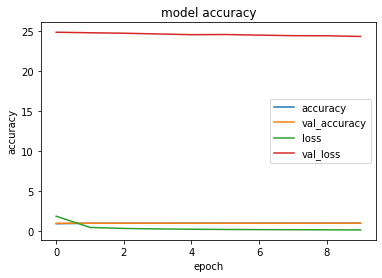

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
plt.show()

In [13]:
# 需要儲存article_id, 轉成dataframe
def predicting_txt_to_dataframe(path):    
    with open(path, 'r') as f:
        txt = str(f.read())
        txt_list = txt.split('\n')
    row_list = list()
    tmp_list = list()
    for row in txt_list:
        if row == '--------------------':
            tmp_list[0] = tmp_list[0].replace('article_id:', '')
            tmp_list[0] = int(tmp_list[0])
            row_list.append(tmp_list)
            tmp_list = list()
            continue
        if len(row) > 0:
            tmp_list.append(row)
    df = pd.DataFrame(row_list, columns=['article_id','text'])
    return df

In [14]:
def predict_NER(text):
    x_list = list()    
    text_list = re.split('\uff0c|\u3002|\uff1f', text)
    for article in text_list:
        x_list.append([i for i in article])
    y_list_list = model.predict(x_list)
    y_list = list()
    for sentence in y_list_list:
        for word in sentence:
            y_list.append(word)
        y_list.append('O') # append(，。？)
    y_list = y_list[:-1]
    return y_list

In [15]:
def output_NER(article_id, text, y_list):
    output_str = str()
    flag = False
    for i, j in enumerate(y_list):
        if j != 'O':
            if j[0] == 'B':
                start_position = i
                entity_type = j.split('-')[-1]
                flag = True
        elif j == 'O' and flag == True:
            end_position = i
            flag = False
            entity_text = text[start_position: end_position]
            entity = '{}\t{}\t{}\t{}\t{}\n'.format(article_id, start_position, end_position, entity_text, entity_type)  
            output_str += entity
    return output_str

In [16]:
df = predicting_txt_to_dataframe('/home/Danny/AI-CUP-2020/datasets/stage5/test.txt')
output_str = "article_id\tstart_position\tend_position\tentity_text\tentity_type\n"

for article_id, text in zip(df['article_id'], df['text']):
    x_list = [word for word in text]
    y_list = predict_NER(text)
    output_str += output_NER(article_id, text, y_list)

2020-12-15 10:38:45,020 [DEBUG] kashgari - predict seq_length: None, input: (2, 70, 17)


3/3 [==============================] - 0s 22ms/step


2020-12-15 10:38:48,787 [DEBUG] kashgari - predict output: (70, 17)
2020-12-15 10:38:48,788 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 0 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:38:48,792 [DEBUG] kashgari - predict seq_length: None, input: (2, 131, 28)


5/5 [==============================] - 0s 37ms/step


2020-12-15 10:38:52,960 [DEBUG] kashgari - predict output: (131, 28)
2020-12-15 10:38:52,961 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:38:52,967 [DEBUG] kashgari - predict seq_length: None, input: (2, 198, 47)


7/7 [==============================] - 0s 59ms/step


2020-12-15 10:38:57,520 [DEBUG] kashgari - predict output: (198, 47)
2020-12-15 10:38:57,521 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-15 10:38:57,523 [DEBUG] kashgari - predict seq_length: None, input: (2, 96, 41)


3/3 [==============================] - 0s 37ms/step


2020-12-15 10:39:00,466 [DEBUG] kashgari - predict output: (96, 41)
2020-12-15 10:39:00,467 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:39:00,469 [DEBUG] kashgari - predict seq_length: None, input: (2, 73, 17)


3/3 [==============================] - 0s 24ms/step


2020-12-15 10:39:00,606 [DEBUG] kashgari - predict output: (73, 17)
2020-12-15 10:39:00,607 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 9 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:39:00,612 [DEBUG] kashgari - predict seq_length: None, input: (2, 266, 23)


9/9 [==============================] - 0s 41ms/step


2020-12-15 10:39:04,737 [DEBUG] kashgari - predict output: (266, 23)
2020-12-15 10:39:04,738 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-15 10:39:04,745 [DEBUG] kashgari - predict seq_length: None, input: (2, 308, 21)


10/10 [==============================] - 0s 38ms/step


2020-12-15 10:39:08,840 [DEBUG] kashgari - predict output: (308, 21)
2020-12-15 10:39:08,841 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:39:08,844 [DEBUG] kashgari - predict seq_length: None, input: (2, 139, 38)


5/5 [==============================] - 0s 45ms/step


2020-12-15 10:39:12,832 [DEBUG] kashgari - predict output: (139, 38)
2020-12-15 10:39:12,833 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:39:12,837 [DEBUG] kashgari - predict seq_length: None, input: (2, 167, 22)


6/6 [==============================] - 0s 34ms/step


2020-12-15 10:39:17,256 [DEBUG] kashgari - predict output: (167, 22)
2020-12-15 10:39:17,257 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 2 2 2]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:39:17,262 [DEBUG] kashgari - predict seq_length: None, input: (2, 272, 41)


9/9 [==============================] - 0s 52ms/step


2020-12-15 10:39:21,508 [DEBUG] kashgari - predict output: (272, 41)
2020-12-15 10:39:21,509 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 7 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:39:21,512 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 63)


5/5 [==============================] - 0s 67ms/step


2020-12-15 10:39:25,623 [DEBUG] kashgari - predict output: (143, 63)
2020-12-15 10:39:25,624 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:39:25,631 [DEBUG] kashgari - predict seq_length: None, input: (2, 663, 42)


21/21 [==============================] - 1s 58ms/step


2020-12-15 10:39:30,600 [DEBUG] kashgari - predict output: (663, 42)
2020-12-15 10:39:30,601 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:39:30,604 [DEBUG] kashgari - predict seq_length: None, input: (2, 39, 25)


2/2 [==============================] - 0s 16ms/step


2020-12-15 10:39:34,357 [DEBUG] kashgari - predict output: (39, 25)
2020-12-15 10:39:34,360 [DEBUG] kashgari - predict output argmax: [[0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 0 1 1 1 

6/6 [==============================] - 0s 35ms/step


2020-12-15 10:39:34,641 [DEBUG] kashgari - predict output: (175, 22)
2020-12-15 10:39:34,642 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:39:34,645 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 28)


5/5 [==============================] - 0s 40ms/step


2020-12-15 10:39:34,923 [DEBUG] kashgari - predict output: (143, 28)
2020-12-15 10:39:34,924 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:39:34,926 [DEBUG] kashgari - predict seq_length: None, input: (2, 88, 21)


3/3 [==============================] - 0s 24ms/step


2020-12-15 10:39:35,062 [DEBUG] kashgari - predict output: (88, 21)
2020-12-15 10:39:35,063 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:39:35,066 [DEBUG] kashgari - predict seq_length: None, input: (2, 121, 28)


4/4 [==============================] - 0s 34ms/step


2020-12-15 10:39:35,275 [DEBUG] kashgari - predict output: (121, 28)
2020-12-15 10:39:35,276 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:39:35,278 [DEBUG] kashgari - predict seq_length: None, input: (2, 85, 27)


3/3 [==============================] - 0s 29ms/step


2020-12-15 10:39:39,708 [DEBUG] kashgari - predict output: (85, 27)
2020-12-15 10:39:39,709 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:39:39,714 [DEBUG] kashgari - predict seq_length: None, input: (2, 255, 19)


8/8 [==============================] - 0s 36ms/step


2020-12-15 10:39:43,718 [DEBUG] kashgari - predict output: (255, 19)
2020-12-15 10:39:43,719 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:39:43,724 [DEBUG] kashgari - predict seq_length: None, input: (2, 202, 29)


7/7 [==============================] - 0s 41ms/step


2020-12-15 10:39:47,848 [DEBUG] kashgari - predict output: (202, 29)
2020-12-15 10:39:47,849 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:39:47,851 [DEBUG] kashgari - predict seq_length: None, input: (2, 198, 19)


7/7 [==============================] - 0s 31ms/step


2020-12-15 10:39:48,132 [DEBUG] kashgari - predict output: (198, 19)
2020-12-15 10:39:48,133 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 6 6 6]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:39:48,136 [DEBUG] kashgari - predict seq_length: None, input: (2, 102, 39)


4/4 [==============================] - 0s 41ms/step


2020-12-15 10:39:52,051 [DEBUG] kashgari - predict output: (102, 39)
2020-12-15 10:39:52,052 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:39:52,054 [DEBUG] kashgari - predict seq_length: None, input: (2, 72, 36)


3/3 [==============================] - 0s 33ms/step


2020-12-15 10:39:55,884 [DEBUG] kashgari - predict output: (72, 36)
2020-12-15 10:39:55,885 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:39:55,889 [DEBUG] kashgari - predict seq_length: None, input: (2, 246, 27)


8/8 [==============================] - 0s 42ms/step


2020-12-15 10:39:56,305 [DEBUG] kashgari - predict output: (246, 27)
2020-12-15 10:39:56,306 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:39:56,309 [DEBUG] kashgari - predict seq_length: None, input: (2, 57, 34)


2/2 [==============================] - 0s 27ms/step


2020-12-15 10:40:00,139 [DEBUG] kashgari - predict output: (57, 34)
2020-12-15 10:40:00,140 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:00,143 [DEBUG] kashgari - predict seq_length: None, input: (2, 82, 21)


3/3 [==============================] - 0s 27ms/step


2020-12-15 10:40:00,293 [DEBUG] kashgari - predict output: (82, 21)
2020-12-15 10:40:00,294 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:00,298 [DEBUG] kashgari - predict seq_length: None, input: (2, 185, 32)


6/6 [==============================] - 0s 45ms/step


2020-12-15 10:40:05,083 [DEBUG] kashgari - predict output: (185, 32)
2020-12-15 10:40:05,084 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:05,086 [DEBUG] kashgari - predict seq_length: None, input: (2, 148, 28)


5/5 [==============================] - 0s 37ms/step


2020-12-15 10:40:05,343 [DEBUG] kashgari - predict output: (148, 28)
2020-12-15 10:40:05,344 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:05,348 [DEBUG] kashgari - predict seq_length: None, input: (2, 281, 23)


9/9 [==============================] - 0s 38ms/step


2020-12-15 10:40:05,764 [DEBUG] kashgari - predict output: (281, 23)
2020-12-15 10:40:05,765 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:05,767 [DEBUG] kashgari - predict seq_length: None, input: (2, 116, 20)


4/4 [==============================] - 0s 30ms/step


2020-12-15 10:40:10,030 [DEBUG] kashgari - predict output: (116, 20)
2020-12-15 10:40:10,031 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:10,034 [DEBUG] kashgari - predict seq_length: None, input: (2, 168, 25)


6/6 [==============================] - 0s 38ms/step


2020-12-15 10:40:10,340 [DEBUG] kashgari - predict output: (168, 25)
2020-12-15 10:40:10,341 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 3 2 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:10,346 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 30)


7/7 [==============================] - 0s 47ms/step


2020-12-15 10:40:14,463 [DEBUG] kashgari - predict output: (218, 30)
2020-12-15 10:40:14,464 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:14,466 [DEBUG] kashgari - predict seq_length: None, input: (2, 123, 32)


4/4 [==============================] - 0s 39ms/step


2020-12-15 10:40:14,706 [DEBUG] kashgari - predict output: (123, 32)
2020-12-15 10:40:14,707 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:14,709 [DEBUG] kashgari - predict seq_length: None, input: (2, 82, 21)


3/3 [==============================] - 0s 25ms/step


2020-12-15 10:40:14,858 [DEBUG] kashgari - predict output: (82, 21)
2020-12-15 10:40:14,859 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 3 2 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:14,862 [DEBUG] kashgari - predict seq_length: None, input: (2, 95, 19)


3/3 [==============================] - 0s 26ms/step


2020-12-15 10:40:15,008 [DEBUG] kashgari - predict output: (95, 19)
2020-12-15 10:40:15,009 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 3 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:15,013 [DEBUG] kashgari - predict seq_length: None, input: (2, 245, 24)


8/8 [==============================] - 0s 38ms/step


2020-12-15 10:40:19,440 [DEBUG] kashgari - predict output: (245, 24)
2020-12-15 10:40:19,441 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 3 ... 5 5 5]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:19,444 [DEBUG] kashgari - predict seq_length: None, input: (2, 126, 31)


4/4 [==============================] - 0s 41ms/step


2020-12-15 10:40:23,776 [DEBUG] kashgari - predict output: (126, 31)
2020-12-15 10:40:23,777 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 3 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:23,779 [DEBUG] kashgari - predict seq_length: None, input: (2, 64, 19)


2/2 [==============================] - 0s 17ms/step


2020-12-15 10:40:26,789 [DEBUG] kashgari - predict output: (64, 19)
2020-12-15 10:40:26,790 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:26,792 [DEBUG] kashgari - predict seq_length: None, input: (2, 93, 24)


3/3 [==============================] - 0s 31ms/step


2020-12-15 10:40:26,958 [DEBUG] kashgari - predict output: (93, 24)
2020-12-15 10:40:26,959 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:26,963 [DEBUG] kashgari - predict seq_length: None, input: (2, 214, 16)


7/7 [==============================] - 0s 33ms/step


2020-12-15 10:40:31,017 [DEBUG] kashgari - predict output: (214, 16)
2020-12-15 10:40:31,018 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:31,020 [DEBUG] kashgari - predict seq_length: None, input: (2, 53, 20)


2/2 [==============================] - 0s 19ms/step


2020-12-15 10:40:31,126 [DEBUG] kashgari - predict output: (53, 20)
2020-12-15 10:40:31,127 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:31,133 [DEBUG] kashgari - predict seq_length: None, input: (2, 384, 18)


12/12 [==============================] - 0s 27ms/step


2020-12-15 10:40:34,140 [DEBUG] kashgari - predict output: (384, 18)
2020-12-15 10:40:34,140 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:34,144 [DEBUG] kashgari - predict seq_length: None, input: (2, 172, 24)


6/6 [==============================] - 0s 35ms/step


2020-12-15 10:40:34,423 [DEBUG] kashgari - predict output: (172, 24)
2020-12-15 10:40:34,424 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:34,427 [DEBUG] kashgari - predict seq_length: None, input: (2, 114, 24)


4/4 [==============================] - 0s 31ms/step


2020-12-15 10:40:34,617 [DEBUG] kashgari - predict output: (114, 24)
2020-12-15 10:40:34,618 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 2 2 2]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:34,621 [DEBUG] kashgari - predict seq_length: None, input: (2, 111, 47)


4/4 [==============================] - 0s 49ms/step


2020-12-15 10:40:34,918 [DEBUG] kashgari - predict output: (111, 47)
2020-12-15 10:40:34,919 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:34,924 [DEBUG] kashgari - predict seq_length: None, input: (2, 350, 34)


11/11 [==============================] - 1s 48ms/step


2020-12-15 10:40:35,534 [DEBUG] kashgari - predict output: (350, 34)
2020-12-15 10:40:35,535 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:35,537 [DEBUG] kashgari - predict seq_length: None, input: (2, 56, 20)


2/2 [==============================] - 0s 18ms/step


2020-12-15 10:40:35,632 [DEBUG] kashgari - predict output: (56, 20)
2020-12-15 10:40:35,633 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:35,636 [DEBUG] kashgari - predict seq_length: None, input: (2, 131, 17)


5/5 [==============================] - 0s 27ms/step


2020-12-15 10:40:35,835 [DEBUG] kashgari - predict output: (131, 17)
2020-12-15 10:40:35,836 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:35,841 [DEBUG] kashgari - predict seq_length: None, input: (2, 184, 34)


6/6 [==============================] - 0s 43ms/step


2020-12-15 10:40:36,181 [DEBUG] kashgari - predict output: (184, 34)
2020-12-15 10:40:36,182 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:36,185 [DEBUG] kashgari - predict seq_length: None, input: (2, 133, 51)


5/5 [==============================] - 0s 56ms/step


2020-12-15 10:40:41,349 [DEBUG] kashgari - predict output: (133, 51)
2020-12-15 10:40:41,350 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 9 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:41,352 [DEBUG] kashgari - predict seq_length: None, input: (2, 210, 53)


7/7 [==============================] - 0s 64ms/step


2020-12-15 10:40:45,597 [DEBUG] kashgari - predict output: (210, 53)
2020-12-15 10:40:45,598 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 5 5 5]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:45,601 [DEBUG] kashgari - predict seq_length: None, input: (2, 193, 55)


7/7 [==============================] - 0s 59ms/step


2020-12-15 10:40:49,836 [DEBUG] kashgari - predict output: (193, 55)
2020-12-15 10:40:49,837 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 9 5 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:49,839 [DEBUG] kashgari - predict seq_length: None, input: (2, 75, 30)


3/3 [==============================] - 0s 28ms/step


2020-12-15 10:40:49,994 [DEBUG] kashgari - predict output: (75, 30)
2020-12-15 10:40:49,995 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:50,001 [DEBUG] kashgari - predict seq_length: None, input: (2, 280, 46)


9/9 [==============================] - 1s 64ms/step


2020-12-15 10:40:54,459 [DEBUG] kashgari - predict output: (280, 46)
2020-12-15 10:40:54,460 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:54,463 [DEBUG] kashgari - predict seq_length: None, input: (2, 210, 20)


7/7 [==============================] - 0s 32ms/step


2020-12-15 10:40:54,753 [DEBUG] kashgari - predict output: (210, 20)
2020-12-15 10:40:54,754 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:54,757 [DEBUG] kashgari - predict seq_length: None, input: (2, 176, 24)


6/6 [==============================] - 0s 35ms/step


2020-12-15 10:40:55,033 [DEBUG] kashgari - predict output: (176, 24)
2020-12-15 10:40:55,034 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:55,039 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 25)


7/7 [==============================] - 0s 37ms/step


2020-12-15 10:40:55,373 [DEBUG] kashgari - predict output: (218, 25)
2020-12-15 10:40:55,374 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:55,377 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 23)


3/3 [==============================] - 0s 28ms/step


2020-12-15 10:40:55,530 [DEBUG] kashgari - predict output: (91, 23)
2020-12-15 10:40:55,530 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:55,534 [DEBUG] kashgari - predict seq_length: None, input: (2, 194, 28)


7/7 [==============================] - 0s 36ms/step


2020-12-15 10:40:55,864 [DEBUG] kashgari - predict output: (194, 28)
2020-12-15 10:40:55,865 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 2 2 2]
 ...
 [0 3 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:55,868 [DEBUG] kashgari - predict seq_length: None, input: (2, 179, 23)


6/6 [==============================] - 0s 35ms/step


2020-12-15 10:40:56,150 [DEBUG] kashgari - predict output: (179, 23)
2020-12-15 10:40:56,151 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:40:56,156 [DEBUG] kashgari - predict seq_length: None, input: (2, 234, 40)


8/8 [==============================] - 0s 53ms/step


2020-12-15 10:41:00,777 [DEBUG] kashgari - predict output: (234, 40)
2020-12-15 10:41:00,777 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:00,781 [DEBUG] kashgari - predict seq_length: None, input: (2, 250, 26)


8/8 [==============================] - 0s 41ms/step


2020-12-15 10:41:04,998 [DEBUG] kashgari - predict output: (250, 26)
2020-12-15 10:41:04,999 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:05,003 [DEBUG] kashgari - predict seq_length: None, input: (2, 170, 43)


6/6 [==============================] - 0s 52ms/step


2020-12-15 10:41:09,082 [DEBUG] kashgari - predict output: (170, 43)
2020-12-15 10:41:09,083 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:09,086 [DEBUG] kashgari - predict seq_length: None, input: (2, 145, 34)


5/5 [==============================] - 0s 41ms/step


2020-12-15 10:41:09,374 [DEBUG] kashgari - predict output: (145, 34)
2020-12-15 10:41:09,375 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 3 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:09,379 [DEBUG] kashgari - predict seq_length: None, input: (2, 102, 29)


4/4 [==============================] - 0s 32ms/step


2020-12-15 10:41:09,583 [DEBUG] kashgari - predict output: (102, 29)
2020-12-15 10:41:09,584 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:09,590 [DEBUG] kashgari - predict seq_length: None, input: (2, 340, 20)


11/11 [==============================] - 0s 33ms/step


2020-12-15 10:41:10,021 [DEBUG] kashgari - predict output: (340, 20)
2020-12-15 10:41:10,022 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:10,024 [DEBUG] kashgari - predict seq_length: None, input: (2, 122, 23)


4/4 [==============================] - 0s 30ms/step


2020-12-15 10:41:10,210 [DEBUG] kashgari - predict output: (122, 23)
2020-12-15 10:41:10,211 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 3 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:10,217 [DEBUG] kashgari - predict seq_length: None, input: (2, 381, 28)


12/12 [==============================] - 1s 42ms/step


2020-12-15 10:41:10,801 [DEBUG] kashgari - predict output: (381, 28)
2020-12-15 10:41:10,802 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:10,805 [DEBUG] kashgari - predict seq_length: None, input: (2, 244, 27)


8/8 [==============================] - 0s 39ms/step


2020-12-15 10:41:11,195 [DEBUG] kashgari - predict output: (244, 27)
2020-12-15 10:41:11,196 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:11,200 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 46)


3/3 [==============================] - 0s 45ms/step


2020-12-15 10:41:11,439 [DEBUG] kashgari - predict output: (91, 46)
2020-12-15 10:41:11,440 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:11,444 [DEBUG] kashgari - predict seq_length: None, input: (2, 223, 42)


7/7 [==============================] - 0s 52ms/step


2020-12-15 10:41:11,900 [DEBUG] kashgari - predict output: (223, 42)
2020-12-15 10:41:11,900 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:11,902 [DEBUG] kashgari - predict seq_length: None, input: (2, 146, 25)


5/5 [==============================] - 0s 33ms/step


2020-12-15 10:41:12,138 [DEBUG] kashgari - predict output: (146, 25)
2020-12-15 10:41:12,139 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:12,143 [DEBUG] kashgari - predict seq_length: None, input: (2, 162, 23)


6/6 [==============================] - 0s 33ms/step


2020-12-15 10:41:12,410 [DEBUG] kashgari - predict output: (162, 23)
2020-12-15 10:41:12,411 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:12,415 [DEBUG] kashgari - predict seq_length: None, input: (2, 244, 27)


8/8 [==============================] - 0s 40ms/step


2020-12-15 10:41:12,805 [DEBUG] kashgari - predict output: (244, 27)
2020-12-15 10:41:12,807 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 9 5 ... 5 5 5]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:12,809 [DEBUG] kashgari - predict seq_length: None, input: (2, 170, 18)


6/6 [==============================] - 0s 32ms/step


2020-12-15 10:41:16,851 [DEBUG] kashgari - predict output: (170, 18)
2020-12-15 10:41:16,852 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 0 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:16,856 [DEBUG] kashgari - predict seq_length: None, input: (2, 199, 36)


7/7 [==============================] - 0s 48ms/step


2020-12-15 10:41:17,282 [DEBUG] kashgari - predict output: (199, 36)
2020-12-15 10:41:17,283 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:17,291 [DEBUG] kashgari - predict seq_length: None, input: (2, 557, 17)


18/18 [==============================] - 1s 34ms/step


2020-12-15 10:41:17,978 [DEBUG] kashgari - predict output: (557, 17)
2020-12-15 10:41:17,978 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 9 5 ... 5 5 5]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:17,982 [DEBUG] kashgari - predict seq_length: None, input: (2, 278, 42)


9/9 [==============================] - 0s 53ms/step


2020-12-15 10:41:18,566 [DEBUG] kashgari - predict output: (278, 42)
2020-12-15 10:41:18,566 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:18,569 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 19)


3/3 [==============================] - 0s 25ms/step


2020-12-15 10:41:18,706 [DEBUG] kashgari - predict output: (91, 19)
2020-12-15 10:41:18,707 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:18,713 [DEBUG] kashgari - predict seq_length: None, input: (2, 296, 24)


10/10 [==============================] - 0s 38ms/step


2020-12-15 10:41:19,164 [DEBUG] kashgari - predict output: (296, 24)
2020-12-15 10:41:19,165 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:19,168 [DEBUG] kashgari - predict seq_length: None, input: (2, 154, 48)


5/5 [==============================] - 0s 58ms/step


2020-12-15 10:41:23,240 [DEBUG] kashgari - predict output: (154, 48)
2020-12-15 10:41:23,241 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:23,244 [DEBUG] kashgari - predict seq_length: None, input: (2, 206, 37)


7/7 [==============================] - 0s 51ms/step


2020-12-15 10:41:27,587 [DEBUG] kashgari - predict output: (206, 37)
2020-12-15 10:41:27,588 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 9 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:27,592 [DEBUG] kashgari - predict seq_length: None, input: (2, 241, 20)


8/8 [==============================] - 0s 33ms/step


2020-12-15 10:41:27,925 [DEBUG] kashgari - predict output: (241, 20)
2020-12-15 10:41:27,926 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 3 2 ... 2 2 2]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:27,934 [DEBUG] kashgari - predict seq_length: None, input: (2, 459, 31)


15/15 [==============================] - 1s 45ms/step


2020-12-15 10:41:28,695 [DEBUG] kashgari - predict output: (459, 31)
2020-12-15 10:41:28,696 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:28,699 [DEBUG] kashgari - predict seq_length: None, input: (2, 223, 34)


7/7 [==============================] - 0s 44ms/step


2020-12-15 10:41:29,085 [DEBUG] kashgari - predict output: (223, 34)
2020-12-15 10:41:29,086 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:29,091 [DEBUG] kashgari - predict seq_length: None, input: (2, 358, 26)


12/12 [==============================] - 0s 41ms/step


2020-12-15 10:41:29,662 [DEBUG] kashgari - predict output: (358, 26)
2020-12-15 10:41:29,663 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:29,666 [DEBUG] kashgari - predict seq_length: None, input: (2, 72, 20)


3/3 [==============================] - 0s 24ms/step


2020-12-15 10:41:29,804 [DEBUG] kashgari - predict output: (72, 20)
2020-12-15 10:41:29,805 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:29,807 [DEBUG] kashgari - predict seq_length: None, input: (2, 75, 24)


3/3 [==============================] - 0s 26ms/step


2020-12-15 10:41:29,953 [DEBUG] kashgari - predict output: (75, 24)
2020-12-15 10:41:29,954 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:29,958 [DEBUG] kashgari - predict seq_length: None, input: (2, 191, 36)


6/6 [==============================] - 0s 46ms/step


2020-12-15 10:41:30,320 [DEBUG] kashgari - predict output: (191, 36)
2020-12-15 10:41:30,321 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:30,323 [DEBUG] kashgari - predict seq_length: None, input: (2, 149, 19)


5/5 [==============================] - 0s 30ms/step


2020-12-15 10:41:30,538 [DEBUG] kashgari - predict output: (149, 19)
2020-12-15 10:41:30,539 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:30,543 [DEBUG] kashgari - predict seq_length: None, input: (2, 176, 22)


6/6 [==============================] - 0s 32ms/step


2020-12-15 10:41:30,804 [DEBUG] kashgari - predict output: (176, 22)
2020-12-15 10:41:30,805 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 3 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:30,809 [DEBUG] kashgari - predict seq_length: None, input: (2, 112, 45)


4/4 [==============================] - 0s 51ms/step


2020-12-15 10:41:36,242 [DEBUG] kashgari - predict output: (112, 45)
2020-12-15 10:41:36,243 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:36,246 [DEBUG] kashgari - predict seq_length: None, input: (2, 269, 21)


9/9 [==============================] - 0s 34ms/step


2020-12-15 10:41:36,616 [DEBUG] kashgari - predict output: (269, 21)
2020-12-15 10:41:36,618 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:36,621 [DEBUG] kashgari - predict seq_length: None, input: (2, 112, 18)


4/4 [==============================] - 0s 26ms/step


2020-12-15 10:41:36,787 [DEBUG] kashgari - predict output: (112, 18)
2020-12-15 10:41:36,788 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 3 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:36,794 [DEBUG] kashgari - predict seq_length: None, input: (2, 352, 22)


11/11 [==============================] - 0s 30ms/step


2020-12-15 10:41:39,781 [DEBUG] kashgari - predict output: (352, 22)
2020-12-15 10:41:39,781 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:39,785 [DEBUG] kashgari - predict seq_length: None, input: (2, 243, 24)


8/8 [==============================] - 0s 37ms/step


2020-12-15 10:41:40,148 [DEBUG] kashgari - predict output: (243, 24)
2020-12-15 10:41:40,150 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:40,155 [DEBUG] kashgari - predict seq_length: None, input: (2, 340, 27)


11/11 [==============================] - 0s 41ms/step


2020-12-15 10:41:40,681 [DEBUG] kashgari - predict output: (340, 27)
2020-12-15 10:41:40,682 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:40,686 [DEBUG] kashgari - predict seq_length: None, input: (2, 384, 25)


12/12 [==============================] - 0s 33ms/step


2020-12-15 10:41:43,852 [DEBUG] kashgari - predict output: (384, 25)
2020-12-15 10:41:43,854 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:43,857 [DEBUG] kashgari - predict seq_length: None, input: (2, 112, 36)


4/4 [==============================] - 0s 40ms/step


2020-12-15 10:41:44,096 [DEBUG] kashgari - predict output: (112, 36)
2020-12-15 10:41:44,098 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:44,102 [DEBUG] kashgari - predict seq_length: None, input: (2, 222, 28)


7/7 [==============================] - 0s 40ms/step


2020-12-15 10:41:44,458 [DEBUG] kashgari - predict output: (222, 28)
2020-12-15 10:41:44,459 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:44,465 [DEBUG] kashgari - predict seq_length: None, input: (2, 255, 34)


8/8 [==============================] - 0s 46ms/step


2020-12-15 10:41:44,917 [DEBUG] kashgari - predict output: (255, 34)
2020-12-15 10:41:44,918 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:44,920 [DEBUG] kashgari - predict seq_length: None, input: (2, 67, 25)


3/3 [==============================] - 0s 25ms/step


2020-12-15 10:41:45,064 [DEBUG] kashgari - predict output: (67, 25)
2020-12-15 10:41:45,065 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 3 2 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:45,067 [DEBUG] kashgari - predict seq_length: None, input: (2, 77, 53)


3/3 [==============================] - 0s 45ms/step


2020-12-15 10:41:45,310 [DEBUG] kashgari - predict output: (77, 53)
2020-12-15 10:41:45,311 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:45,313 [DEBUG] kashgari - predict seq_length: None, input: (2, 67, 27)


3/3 [==============================] - 0s 27ms/step


2020-12-15 10:41:45,464 [DEBUG] kashgari - predict output: (67, 27)
2020-12-15 10:41:45,465 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:45,467 [DEBUG] kashgari - predict seq_length: None, input: (2, 72, 19)


3/3 [==============================] - 0s 24ms/step


2020-12-15 10:41:45,603 [DEBUG] kashgari - predict output: (72, 19)
2020-12-15 10:41:45,604 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:45,606 [DEBUG] kashgari - predict seq_length: None, input: (2, 98, 24)


4/4 [==============================] - 0s 29ms/step


2020-12-15 10:41:45,795 [DEBUG] kashgari - predict output: (98, 24)
2020-12-15 10:41:45,796 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:45,799 [DEBUG] kashgari - predict seq_length: None, input: (2, 87, 37)


3/3 [==============================] - 0s 32ms/step


2020-12-15 10:41:45,974 [DEBUG] kashgari - predict output: (87, 37)
2020-12-15 10:41:45,975 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:45,981 [DEBUG] kashgari - predict seq_length: None, input: (2, 311, 29)


10/10 [==============================] - 0s 43ms/step


2020-12-15 10:41:46,494 [DEBUG] kashgari - predict output: (311, 29)
2020-12-15 10:41:46,496 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:46,500 [DEBUG] kashgari - predict seq_length: None, input: (2, 447, 20)


14/14 [==============================] - 1s 36ms/step


2020-12-15 10:41:47,077 [DEBUG] kashgari - predict output: (447, 20)
2020-12-15 10:41:47,078 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:47,081 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 19)


7/7 [==============================] - 0s 33ms/step


2020-12-15 10:41:47,375 [DEBUG] kashgari - predict output: (218, 19)
2020-12-15 10:41:47,376 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:47,386 [DEBUG] kashgari - predict seq_length: None, input: (2, 285, 30)


9/9 [==============================] - 0s 44ms/step


2020-12-15 10:41:47,858 [DEBUG] kashgari - predict output: (285, 30)
2020-12-15 10:41:47,859 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 4 4 4]
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:47,864 [DEBUG] kashgari - predict seq_length: None, input: (2, 424, 21)


14/14 [==============================] - 1s 36ms/step


2020-12-15 10:41:48,446 [DEBUG] kashgari - predict output: (424, 21)
2020-12-15 10:41:48,446 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:48,449 [DEBUG] kashgari - predict seq_length: None, input: (2, 94, 30)


3/3 [==============================] - 0s 33ms/step


2020-12-15 10:41:48,621 [DEBUG] kashgari - predict output: (94, 30)
2020-12-15 10:41:48,622 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:48,626 [DEBUG] kashgari - predict seq_length: None, input: (2, 202, 34)


7/7 [==============================] - 0s 44ms/step


2020-12-15 10:41:49,015 [DEBUG] kashgari - predict output: (202, 34)
2020-12-15 10:41:49,016 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:49,021 [DEBUG] kashgari - predict seq_length: None, input: (2, 242, 50)


8/8 [==============================] - 0s 60ms/step


2020-12-15 10:41:53,280 [DEBUG] kashgari - predict output: (242, 50)
2020-12-15 10:41:53,281 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-15 10:41:53,284 [DEBUG] kashgari - predict seq_length: None, input: (2, 269, 38)


9/9 [==============================] - 0s 49ms/step


2020-12-15 10:41:53,810 [DEBUG] kashgari - predict output: (269, 38)
2020-12-15 10:41:53,811 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:53,814 [DEBUG] kashgari - predict seq_length: None, input: (2, 108, 35)


4/4 [==============================] - 0s 39ms/step


2020-12-15 10:41:57,931 [DEBUG] kashgari - predict output: (108, 35)
2020-12-15 10:41:57,932 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:57,936 [DEBUG] kashgari - predict seq_length: None, input: (2, 136, 30)


5/5 [==============================] - 0s 38ms/step


2020-12-15 10:41:58,208 [DEBUG] kashgari - predict output: (136, 30)
2020-12-15 10:41:58,209 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:58,212 [DEBUG] kashgari - predict seq_length: None, input: (2, 217, 28)


7/7 [==============================] - 0s 40ms/step


2020-12-15 10:41:58,566 [DEBUG] kashgari - predict output: (217, 28)
2020-12-15 10:41:58,567 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:58,570 [DEBUG] kashgari - predict seq_length: None, input: (2, 83, 27)


3/3 [==============================] - 0s 28ms/step


2020-12-15 10:41:58,723 [DEBUG] kashgari - predict output: (83, 27)
2020-12-15 10:41:58,724 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:58,730 [DEBUG] kashgari - predict seq_length: None, input: (2, 392, 36)


13/13 [==============================] - 1s 50ms/step


2020-12-15 10:41:59,470 [DEBUG] kashgari - predict output: (392, 36)
2020-12-15 10:41:59,471 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:59,473 [DEBUG] kashgari - predict seq_length: None, input: (2, 108, 41)


4/4 [==============================] - 0s 42ms/step


2020-12-15 10:41:59,732 [DEBUG] kashgari - predict output: (108, 41)
2020-12-15 10:41:59,734 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:41:59,737 [DEBUG] kashgari - predict seq_length: None, input: (2, 221, 26)


7/7 [==============================] - 0s 38ms/step


2020-12-15 10:42:00,075 [DEBUG] kashgari - predict output: (221, 26)
2020-12-15 10:42:00,076 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:00,079 [DEBUG] kashgari - predict seq_length: None, input: (2, 94, 45)


3/3 [==============================] - 0s 44ms/step


2020-12-15 10:42:00,303 [DEBUG] kashgari - predict output: (94, 45)
2020-12-15 10:42:00,304 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:00,306 [DEBUG] kashgari - predict seq_length: None, input: (2, 59, 21)


2/2 [==============================] - 0s 20ms/step


2020-12-15 10:42:00,409 [DEBUG] kashgari - predict output: (59, 21)
2020-12-15 10:42:00,410 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:00,413 [DEBUG] kashgari - predict seq_length: None, input: (2, 101, 33)


4/4 [==============================] - 0s 36ms/step


2020-12-15 10:42:04,341 [DEBUG] kashgari - predict output: (101, 33)
2020-12-15 10:42:04,342 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:04,344 [DEBUG] kashgari - predict seq_length: None, input: (2, 64, 33)


2/2 [==============================] - 0s 22ms/step


2020-12-15 10:42:07,054 [DEBUG] kashgari - predict output: (64, 33)
2020-12-15 10:42:07,055 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:07,057 [DEBUG] kashgari - predict seq_length: None, input: (2, 85, 30)


3/3 [==============================] - 0s 35ms/step


2020-12-15 10:42:07,248 [DEBUG] kashgari - predict output: (85, 30)
2020-12-15 10:42:07,249 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:07,252 [DEBUG] kashgari - predict seq_length: None, input: (2, 89, 33)


3/3 [==============================] - 0s 36ms/step


2020-12-15 10:42:07,439 [DEBUG] kashgari - predict output: (89, 33)
2020-12-15 10:42:07,440 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:07,443 [DEBUG] kashgari - predict seq_length: None, input: (2, 254, 27)


8/8 [==============================] - 0s 41ms/step


2020-12-15 10:42:07,848 [DEBUG] kashgari - predict output: (254, 27)
2020-12-15 10:42:07,849 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 3 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:07,851 [DEBUG] kashgari - predict seq_length: None, input: (2, 129, 29)


5/5 [==============================] - 0s 36ms/step


2020-12-15 10:42:08,103 [DEBUG] kashgari - predict output: (129, 29)
2020-12-15 10:42:08,104 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:08,107 [DEBUG] kashgari - predict seq_length: None, input: (2, 130, 26)


5/5 [==============================] - 0s 34ms/step


2020-12-15 10:42:08,351 [DEBUG] kashgari - predict output: (130, 26)
2020-12-15 10:42:08,352 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:08,355 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 37)


5/5 [==============================] - 0s 44ms/step


2020-12-15 10:42:08,656 [DEBUG] kashgari - predict output: (143, 37)
2020-12-15 10:42:08,656 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:08,659 [DEBUG] kashgari - predict seq_length: None, input: (2, 107, 36)


4/4 [==============================] - 0s 38ms/step


2020-12-15 10:42:08,889 [DEBUG] kashgari - predict output: (107, 36)
2020-12-15 10:42:08,890 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:08,892 [DEBUG] kashgari - predict seq_length: None, input: (2, 70, 28)


3/3 [==============================] - 0s 26ms/step


2020-12-15 10:42:09,041 [DEBUG] kashgari - predict output: (70, 28)
2020-12-15 10:42:09,042 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:09,046 [DEBUG] kashgari - predict seq_length: None, input: (2, 189, 26)


6/6 [==============================] - 0s 38ms/step


2020-12-15 10:42:09,350 [DEBUG] kashgari - predict output: (189, 26)
2020-12-15 10:42:09,351 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:09,353 [DEBUG] kashgari - predict seq_length: None, input: (2, 99, 48)


4/4 [==============================] - 0s 46ms/step


2020-12-15 10:42:09,635 [DEBUG] kashgari - predict output: (99, 48)
2020-12-15 10:42:09,636 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:09,640 [DEBUG] kashgari - predict seq_length: None, input: (2, 213, 35)


7/7 [==============================] - 0s 45ms/step


2020-12-15 10:42:10,042 [DEBUG] kashgari - predict output: (213, 35)
2020-12-15 10:42:10,043 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:10,046 [DEBUG] kashgari - predict seq_length: None, input: (2, 181, 40)


6/6 [==============================] - 0s 48ms/step


2020-12-15 10:42:10,421 [DEBUG] kashgari - predict output: (181, 40)
2020-12-15 10:42:10,422 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:10,424 [DEBUG] kashgari - predict seq_length: None, input: (2, 119, 34)


4/4 [==============================] - 0s 39ms/step


2020-12-15 10:42:10,665 [DEBUG] kashgari - predict output: (119, 34)
2020-12-15 10:42:10,666 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:10,669 [DEBUG] kashgari - predict seq_length: None, input: (2, 188, 52)


6/6 [==============================] - 0s 63ms/step


2020-12-15 10:42:14,924 [DEBUG] kashgari - predict output: (188, 52)
2020-12-15 10:42:14,925 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:14,929 [DEBUG] kashgari - predict seq_length: None, input: (2, 252, 30)


8/8 [==============================] - 0s 43ms/step


2020-12-15 10:42:15,352 [DEBUG] kashgari - predict output: (252, 30)
2020-12-15 10:42:15,353 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 3 2 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:15,357 [DEBUG] kashgari - predict seq_length: None, input: (2, 249, 38)


8/8 [==============================] - 0s 51ms/step


2020-12-15 10:42:15,849 [DEBUG] kashgari - predict output: (249, 38)
2020-12-15 10:42:15,850 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 3 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:15,853 [DEBUG] kashgari - predict seq_length: None, input: (2, 65, 44)


3/3 [==============================] - 0s 37ms/step


2020-12-15 10:42:19,731 [DEBUG] kashgari - predict output: (65, 44)
2020-12-15 10:42:19,732 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:19,738 [DEBUG] kashgari - predict seq_length: None, input: (2, 265, 41)


9/9 [==============================] - 0s 54ms/step


2020-12-15 10:42:20,321 [DEBUG] kashgari - predict output: (265, 41)
2020-12-15 10:42:20,322 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:20,325 [DEBUG] kashgari - predict seq_length: None, input: (2, 163, 33)


6/6 [==============================] - 0s 41ms/step


2020-12-15 10:42:20,649 [DEBUG] kashgari - predict output: (163, 33)
2020-12-15 10:42:20,650 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 2 2 2]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:20,655 [DEBUG] kashgari - predict seq_length: None, input: (2, 166, 33)


6/6 [==============================] - 0s 41ms/step


2020-12-15 10:42:20,979 [DEBUG] kashgari - predict output: (166, 33)
2020-12-15 10:42:20,980 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 3 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:20,983 [DEBUG] kashgari - predict seq_length: None, input: (2, 152, 37)


5/5 [==============================] - 0s 44ms/step


2020-12-15 10:42:21,288 [DEBUG] kashgari - predict output: (152, 37)
2020-12-15 10:42:21,288 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:21,292 [DEBUG] kashgari - predict seq_length: None, input: (2, 129, 26)


5/5 [==============================] - 0s 32ms/step


2020-12-15 10:42:21,525 [DEBUG] kashgari - predict output: (129, 26)
2020-12-15 10:42:21,526 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:21,532 [DEBUG] kashgari - predict seq_length: None, input: (2, 260, 42)


9/9 [==============================] - 0s 51ms/step


2020-12-15 10:42:22,082 [DEBUG] kashgari - predict output: (260, 42)
2020-12-15 10:42:22,083 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:22,090 [DEBUG] kashgari - predict seq_length: None, input: (2, 557, 59)


18/18 [==============================] - 1s 75ms/step


2020-12-15 10:42:27,202 [DEBUG] kashgari - predict output: (557, 59)
2020-12-15 10:42:27,203 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:27,207 [DEBUG] kashgari - predict seq_length: None, input: (2, 144, 72)


5/5 [==============================] - 0s 80ms/step


2020-12-15 10:42:31,394 [DEBUG] kashgari - predict output: (144, 72)
2020-12-15 10:42:31,395 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:31,400 [DEBUG] kashgari - predict seq_length: None, input: (2, 474, 27)


15/15 [==============================] - 1s 42ms/step


2020-12-15 10:42:32,117 [DEBUG] kashgari - predict output: (474, 27)
2020-12-15 10:42:32,118 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:32,122 [DEBUG] kashgari - predict seq_length: None, input: (2, 253, 34)


8/8 [==============================] - 0s 46ms/step


2020-12-15 10:42:32,569 [DEBUG] kashgari - predict output: (253, 34)
2020-12-15 10:42:32,570 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:32,574 [DEBUG] kashgari - predict seq_length: None, input: (2, 210, 45)


7/7 [==============================] - 0s 57ms/step


2020-12-15 10:42:33,071 [DEBUG] kashgari - predict output: (210, 45)
2020-12-15 10:42:33,072 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:33,076 [DEBUG] kashgari - predict seq_length: None, input: (2, 244, 32)


8/8 [==============================] - 0s 45ms/step


2020-12-15 10:42:33,515 [DEBUG] kashgari - predict output: (244, 32)
2020-12-15 10:42:33,516 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:33,522 [DEBUG] kashgari - predict seq_length: None, input: (2, 319, 36)


10/10 [==============================] - 1s 51ms/step


2020-12-15 10:42:34,117 [DEBUG] kashgari - predict output: (319, 36)
2020-12-15 10:42:34,118 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:34,123 [DEBUG] kashgari - predict seq_length: None, input: (2, 437, 36)


14/14 [==============================] - 1s 52ms/step


2020-12-15 10:42:34,946 [DEBUG] kashgari - predict output: (437, 36)
2020-12-15 10:42:34,947 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 10:42:34,950 [DEBUG] kashgari - predict seq_length: None, input: (2, 171, 78)


6/6 [==============================] - 0s 82ms/step


2020-12-15 10:42:39,240 [DEBUG] kashgari - predict output: (171, 78)
2020-12-15 10:42:39,241 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]


In [19]:
output_path = 'output/{}_epoch_{}_batch_{}.tsv'.format(model_name, epochs, batch_size)
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(output_str)

output/bert-chinese_epoch_10_batch_1024.tsv


In [20]:
df = pd.read_csv(output_path, sep='\t')
df

,article_id,start_position,end_position,entity_text,entity_type
0,0,36,38,年底,time
1,0,227,229,麻豆,location
2,0,237,239,麻豆,location
3,1,76,80,0.79,med_exam
4,1,94,96,88,med_exam
...,...,...,...,...,...
2765,158,431,434,二十二,time
2766,158,1082,1086,第三個月,time
2767,158,1143,1145,今天,time
2768,158,1199,1201,小安,name
